## Environment prep 

In [1]:
# Import the required libraries and set the plotting options
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets 
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.api as sm
from patsy import dmatrices

%matplotlib inline
sns.set(rc = {'figure.figsize':(15,10)})

## Background

Predict wine quality base on various factors.

#### Input variables
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

#### Output variables
12. quality (score between 0 and 10)

## Exploratory data analysis

### Red wine
- Total observations: 1599
- Zero null value found
- Output variable `quality` 
    - scores of red wine given between 3 and 8
    - with scores mainly lies between 5 and 7
    - no extreme scores given, e.g. 0 or 10
- most input variables have min and max far from interquatile range, except `density` and `pH` 
    - possible outliers
- all input variables show a sign of rightly skewed except `density` and `pH`
- All VIF <10; No input variable shows a significant multicollinearity

### White wine
- Total observations: 4898
- Zero null value found
- Output variable `quality` 
    - slightly wider range than red wine ranging between 3 and 9
    - with scores mainly lies between 5 and 7
    - no extreme scores given
- most input variables have min and max far from interquatile range, except `density` and `pH` 
    - possible outliers
- all input variables show a sign of rightly skewed except `pH`
- `residual sugar` and `density` have VIF>10, indicates a high collinearity, hence will be removed when performing regression analysis

In [2]:
# Load red and white wine datasets
red = pd.read_csv('winequality/winequality-red.csv', sep=';')
white = pd.read_csv('winequality/winequality-white.csv', sep=';')

In [3]:
display(red)
print(red.shape)
print(red.dtypes)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  
0         9.4        5  
1         9.8        5  
2         9.8        5  
3         9.8        6  
4         9.4        5  
...       ...      ...  
1594     10.5        5  
1595     11.2        6  
1596     11.0        6  
1597     10.2        5  
1598     11.0        6  

[1599 rows x 12 columns]

(1599, 12)
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


In [4]:
display(white)
print(white.shape)
print(white.dtypes)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    45.0                 170.0  1.00100  3.00       0.45   
1                    14.0                 132.0  0.99400  3.30       0.49   
2                    30.0                  97.0  0.99510  3.26       0.44   
3                    47.0                 186.0  0.99560  3.19       0.40   
4                    47.0                 186.0  0.99560  3.19       0.40   
...                   ...                   ...      ...   ...        ...   
4893                 24.0                  92.0  0.99114  3.27       0.50   
4894                 57.0                 168.0  0.99490  3.15       0.46   
4895                 30.0                 111.0  0.99254  2.99       0.46   
4896                 20.0                 110.0  0.98869  3.34       0.38   
4897                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality  
0         8.8        6  
1         9.5        6  
2        10.1        6  
3         9.9        6  
4         9.9        6  
...       ...      ...  
4893     11.2        6  
4894      9.6        5  
4895      9.4        6  
4896     12.8        7  
4897     11.8        6  

[4898 rows x 12 columns]

(4898, 12)
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


In [5]:
# Determine any missing values
print("Rows with missing data for red wine:")
display(red[red.isna().any(axis=1)])
red.isna().sum()

Rows with missing data for red wine:


Empty DataFrame
Columns: [fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality]
Index: []

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
# Determine any missing values
print("Rows with missing data for white wine:")
display(white[white.isna().any(axis=1)])
white.isna().sum()

Rows with missing data for white wine:


Empty DataFrame
Columns: [fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality]
Index: []

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [7]:
# replace spaces in column names with _
colnames = list(red.columns)
colnames2 = {colnames[i]: [x.replace(' ', '_') for x in colnames][i] 
             for i in range(len(colnames))}

red.rename(columns=colnames2, inplace=True)
display(red.head())

white.rename(columns=colnames2, inplace=True)
display(white.head())

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

In [8]:
# summary statistics
print('Red wine summary statistics:')
display(red.describe())

print('White wine summary statistics:')
display(white.describe())

Red wine summary statistics:


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

White wine summary statistics:


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.036000            23.000000            108.000000     0.991723   
50%       0.043000            34.000000            134.000000     0.993740   
75%       0.050000            46.000000            167.000000     0.996100   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  4898.000000  4898.000000  4898.000000  4898.000000  
mean      3.188267     0.489847    10.514267     5.877909  
std       0.151001     0.114126     1.230621     0.885639  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.090000     0.410000     9.500000     5.000000  
50%       3.180000     0.470000    10.400000     6.000000  
75%       3.280000     0.550000    11.400000     6.000000  
max       3.820000     1.080000    14.200000     9.000000

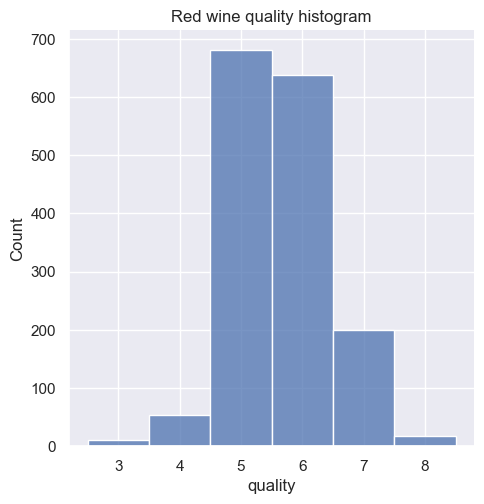

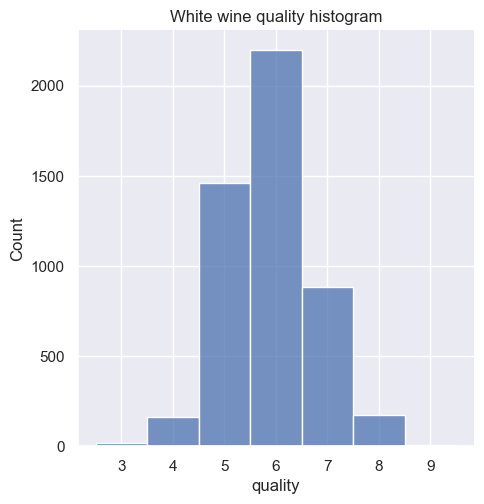

In [9]:
# hist plot for output variables for both variants
red_histplot = sns.displot(red, x='quality', discrete=True).set(title='Red wine quality histogram')
white_histplot = sns.displot(white, x='quality', discrete=True).set(title='White wine quality histogram')


Text(0.5, 1.01, 'White wine pair plot')

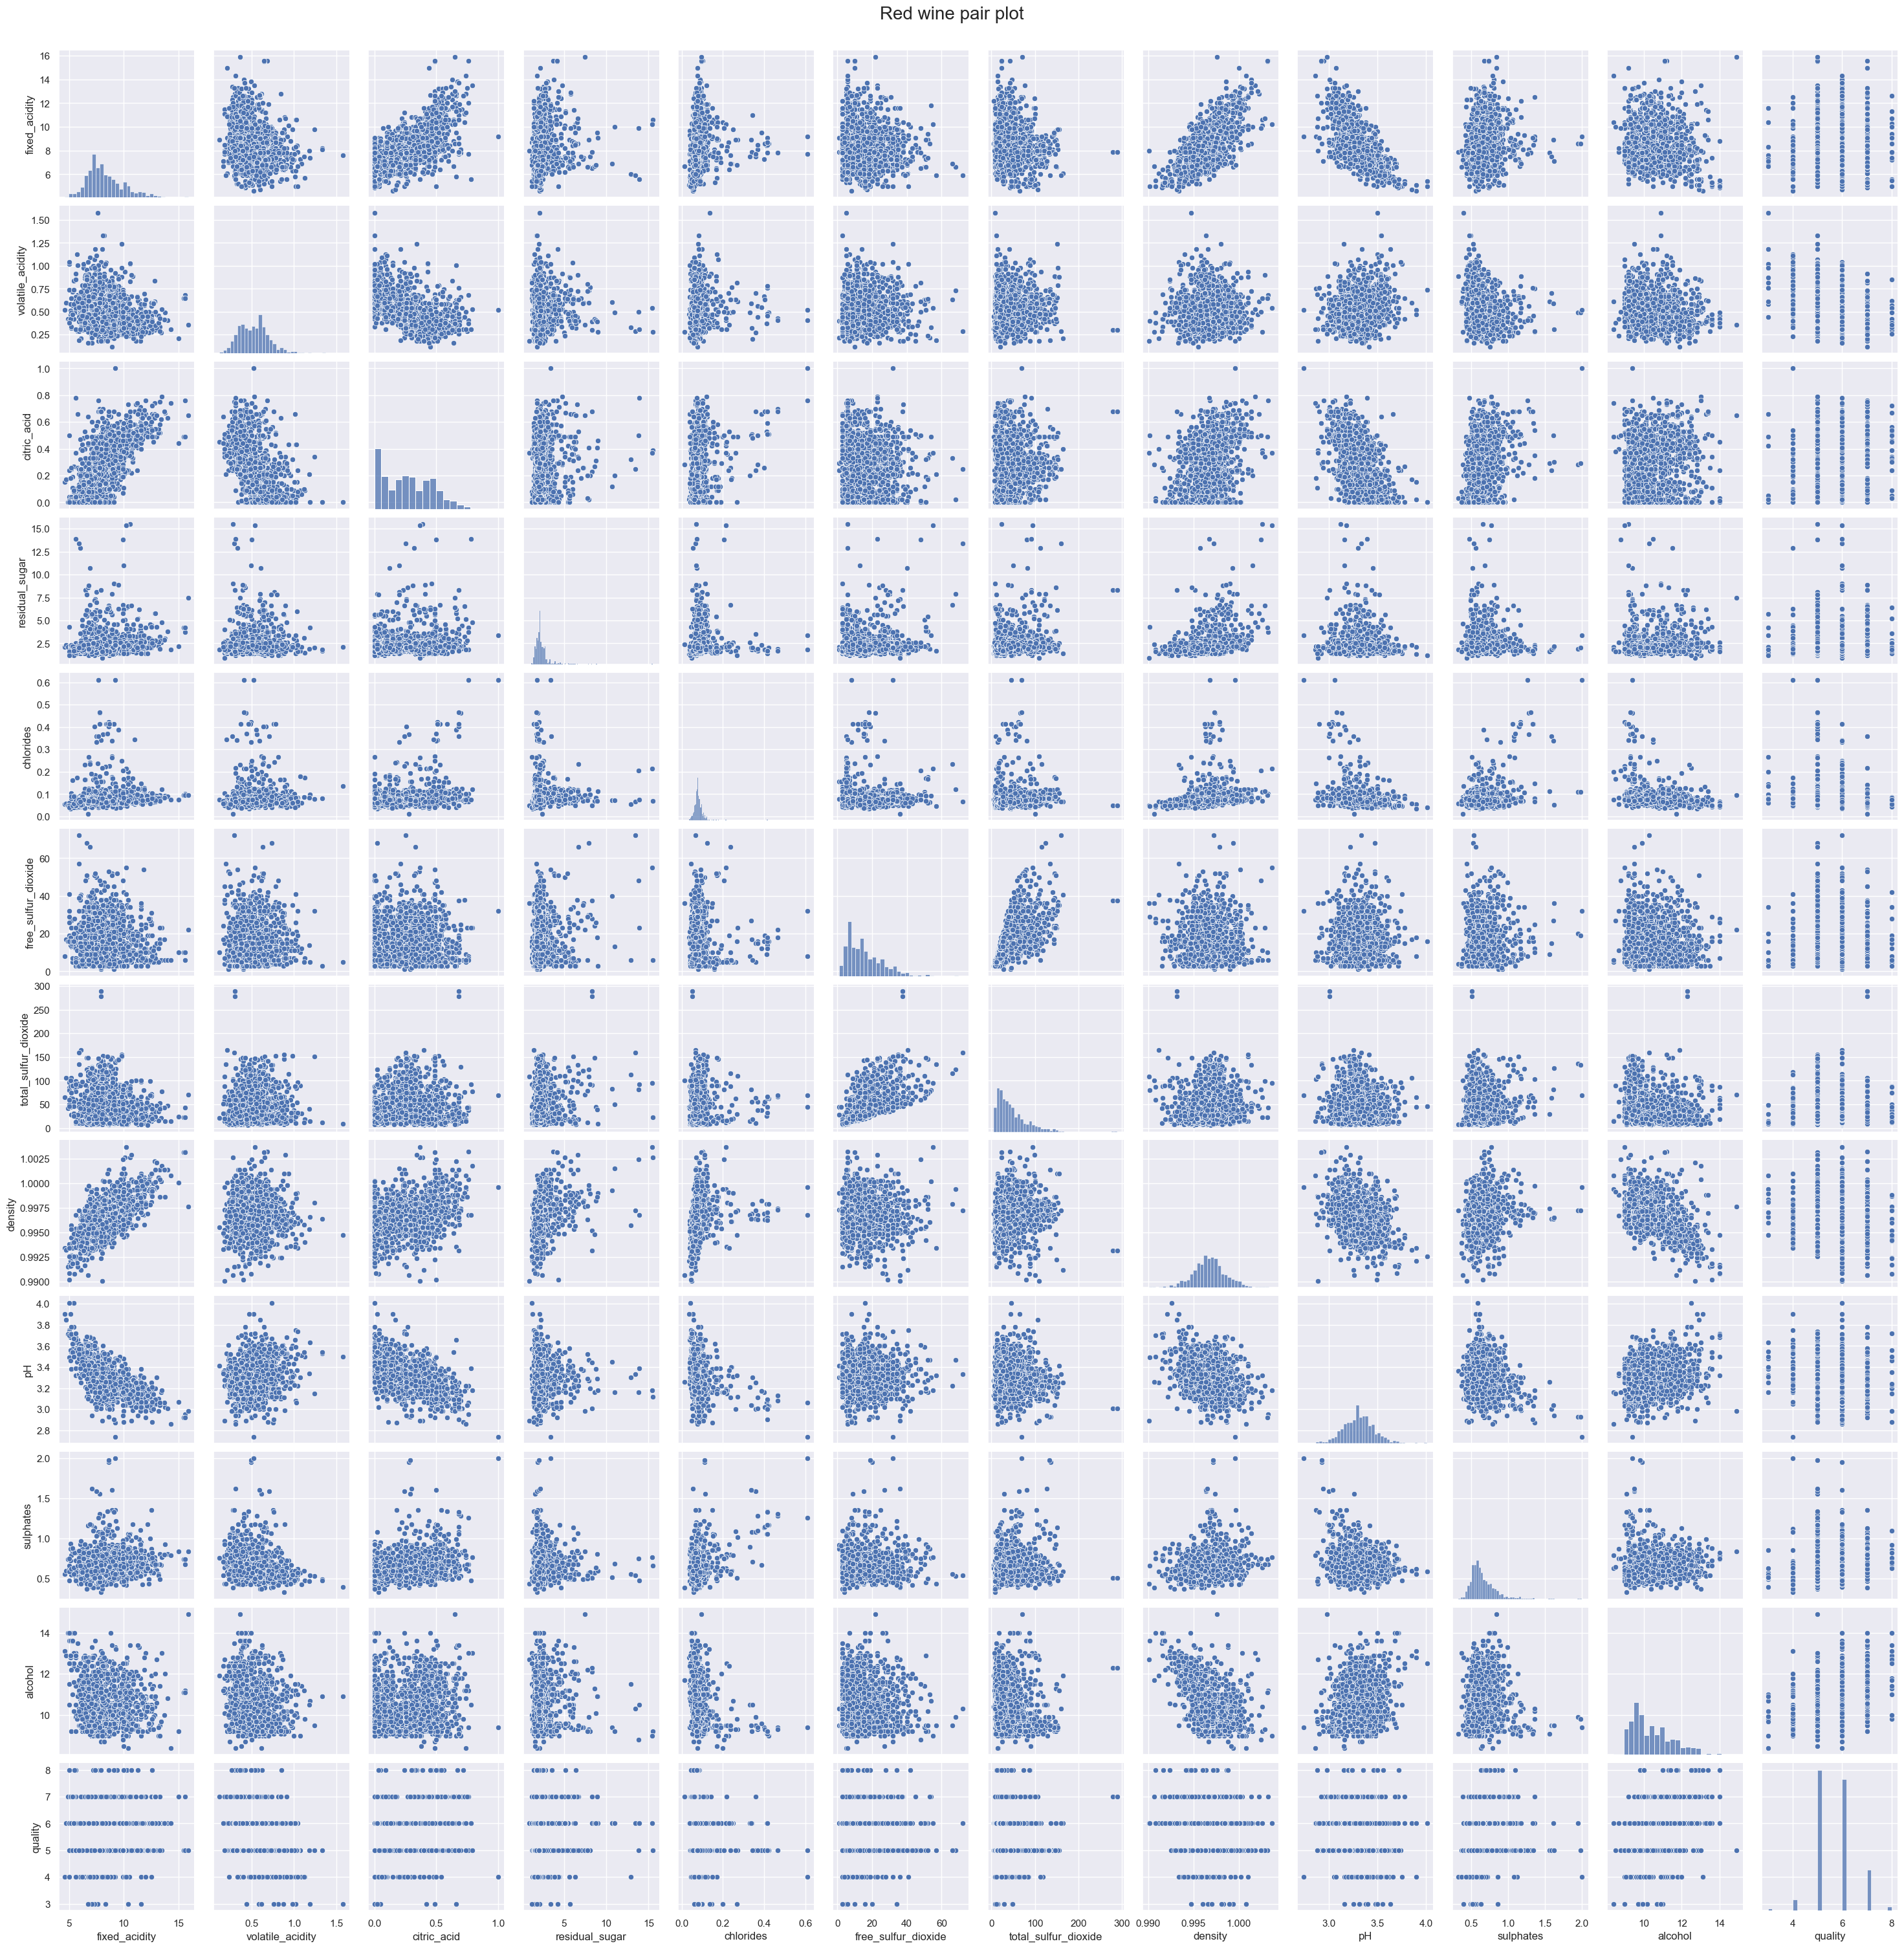

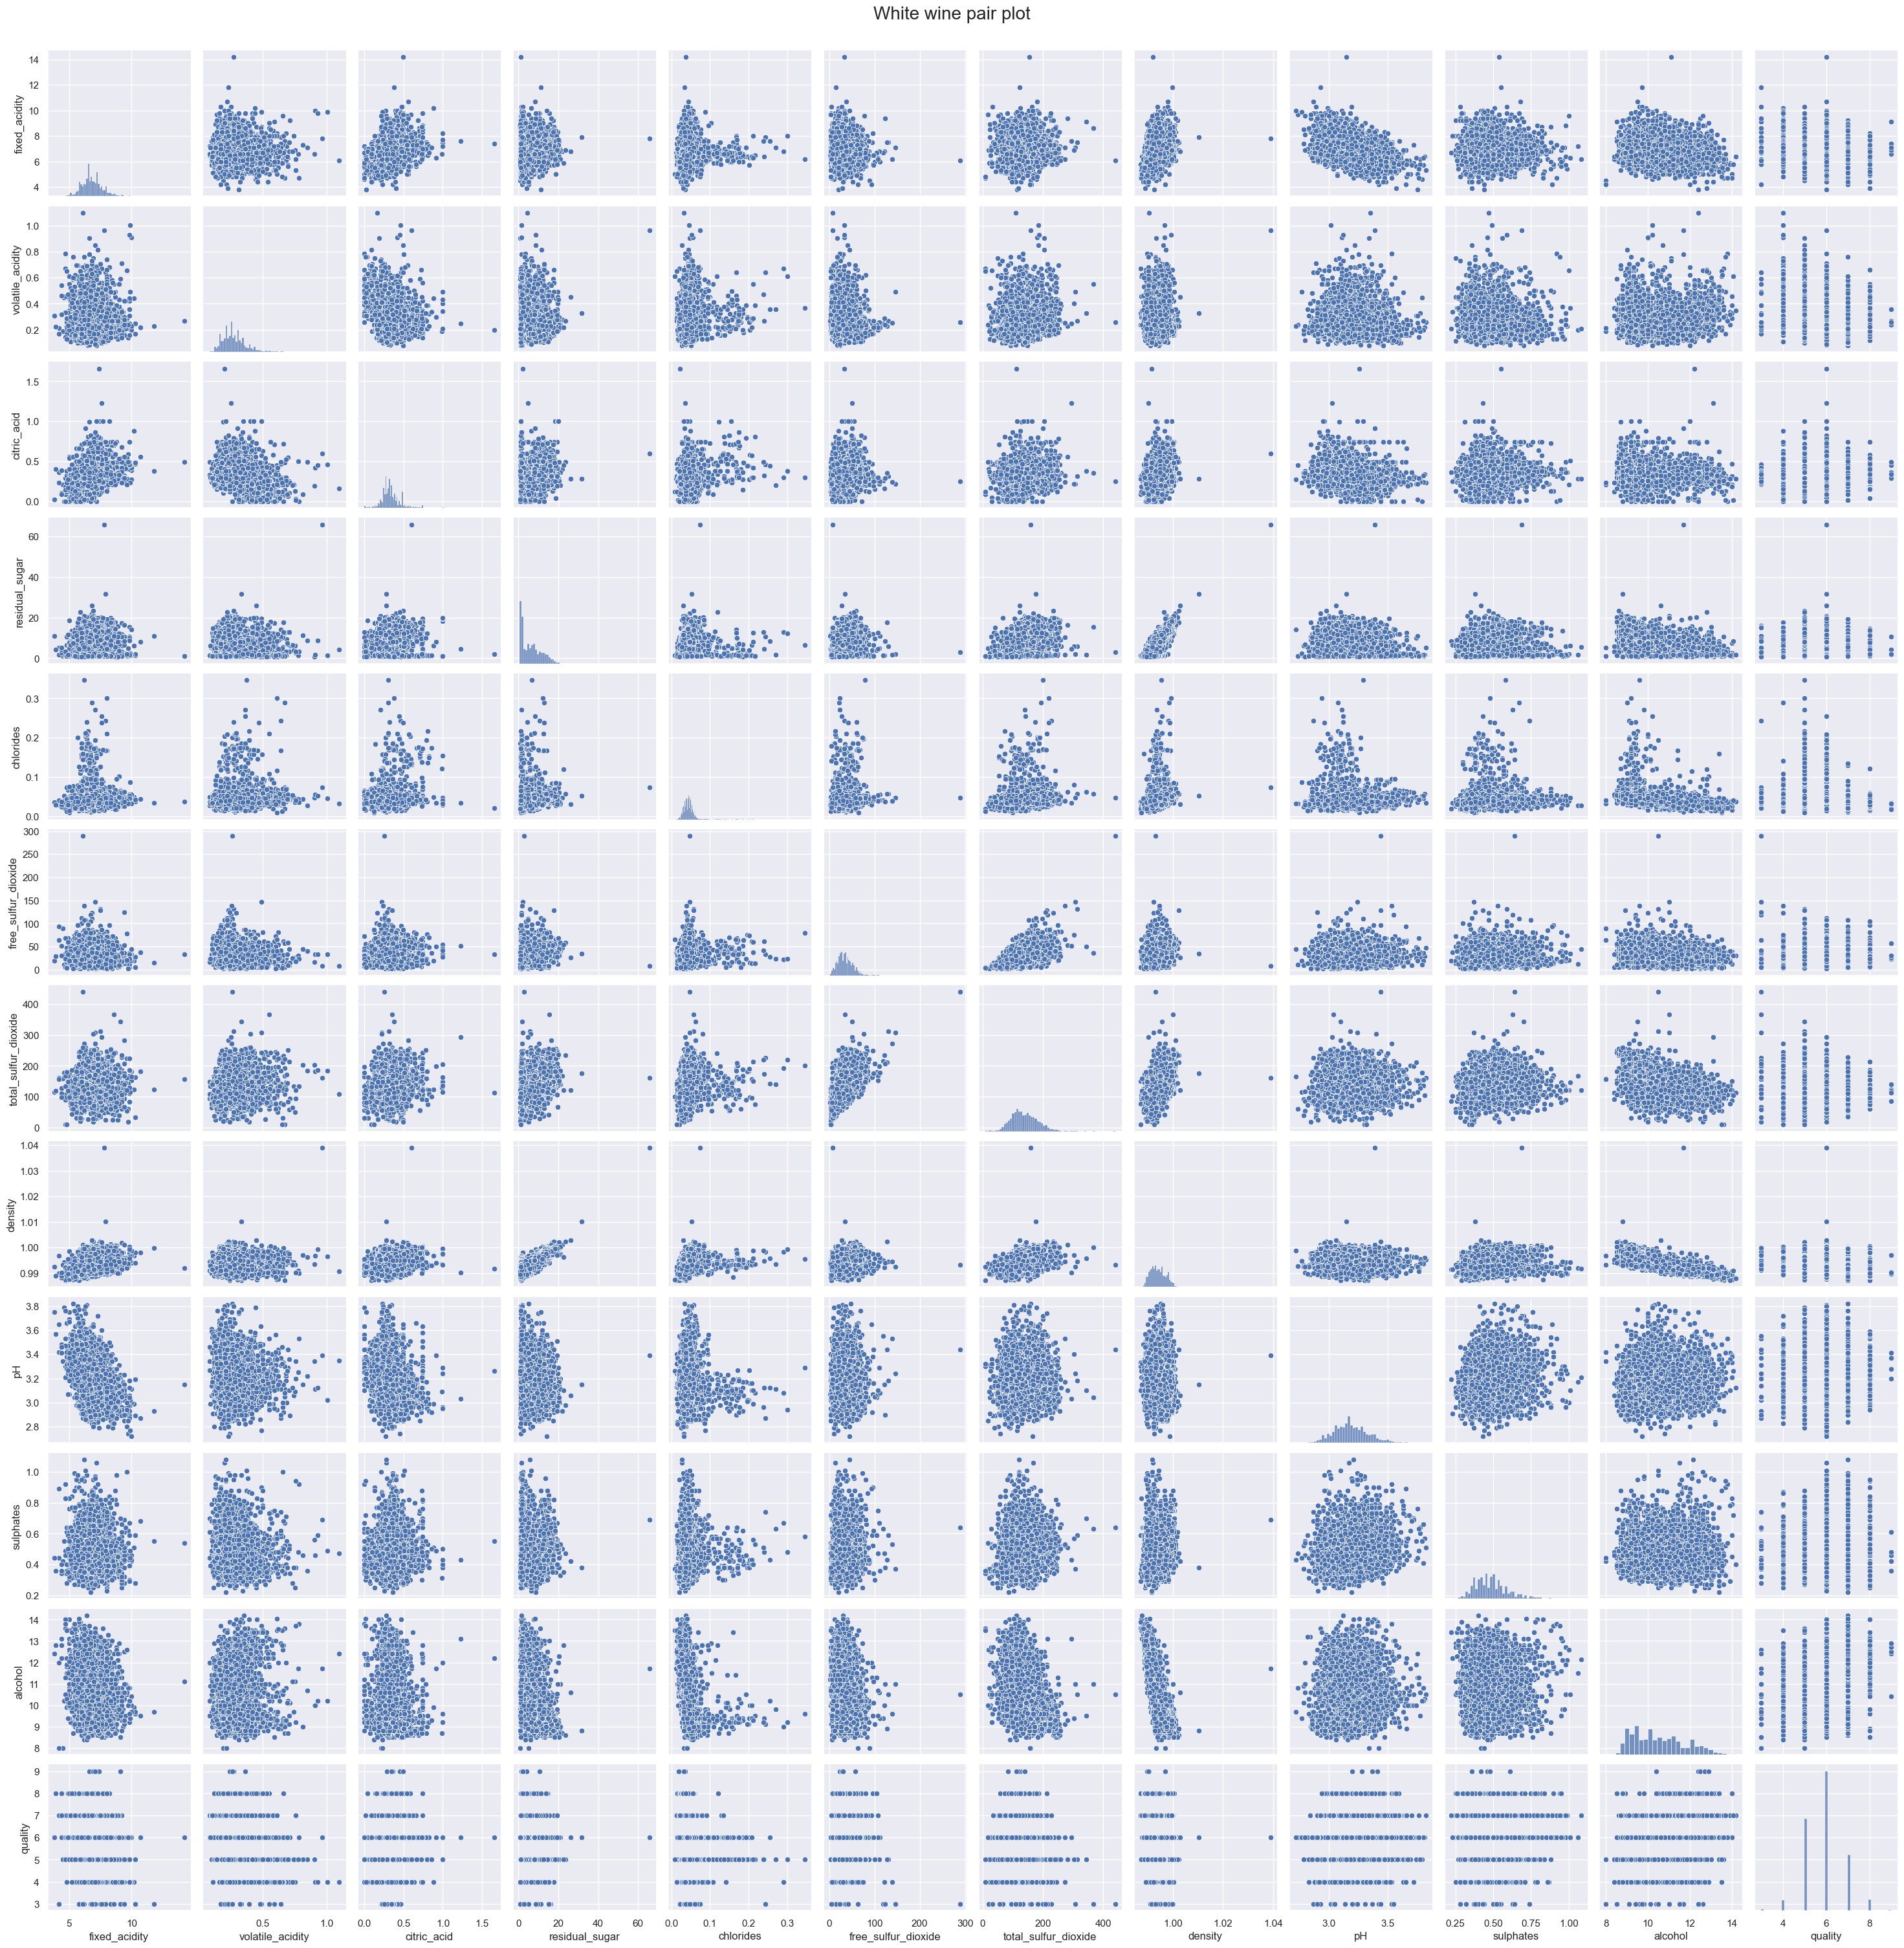

In [10]:
# Quick glance scatterplots
red_pp = sns.pairplot(red)
red_pp.fig.suptitle('Red wine pair plot', y=1.01, size=20)
white_pp = sns.pairplot(white)
white_pp.fig.suptitle('White wine pair plot', y=1.01, size=20)

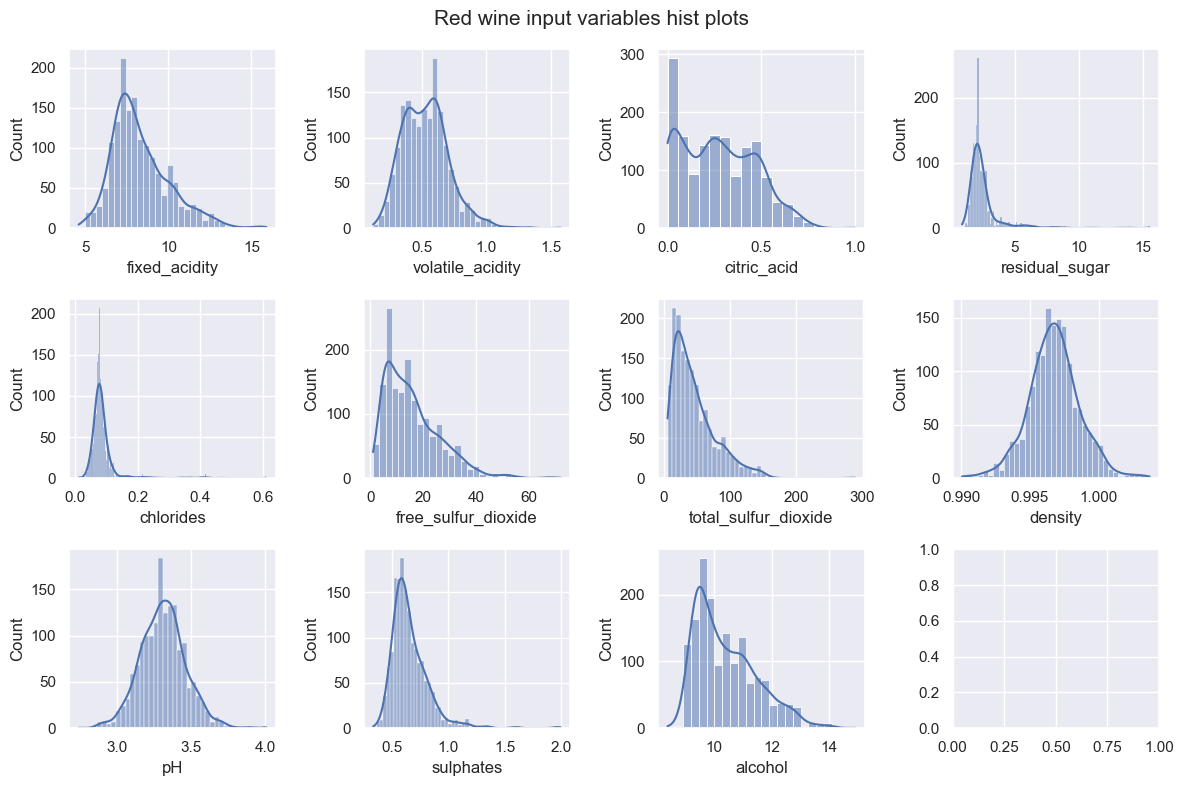

In [11]:
# hist plot for all input variables for both variants
n = red.shape[1]-1 # num of cols less output variable

fig, axs = plt.subplots(math.ceil(n/4), 4, figsize = (12,8))
plt.suptitle('Red wine input variables hist plots', fontsize=15)

for i in range(0,n):
    plt.subplot(math.ceil(n/4), 4, i+1)
    sns.histplot(red.iloc[:, i], kde=True)

plt.tight_layout()
plt.show()

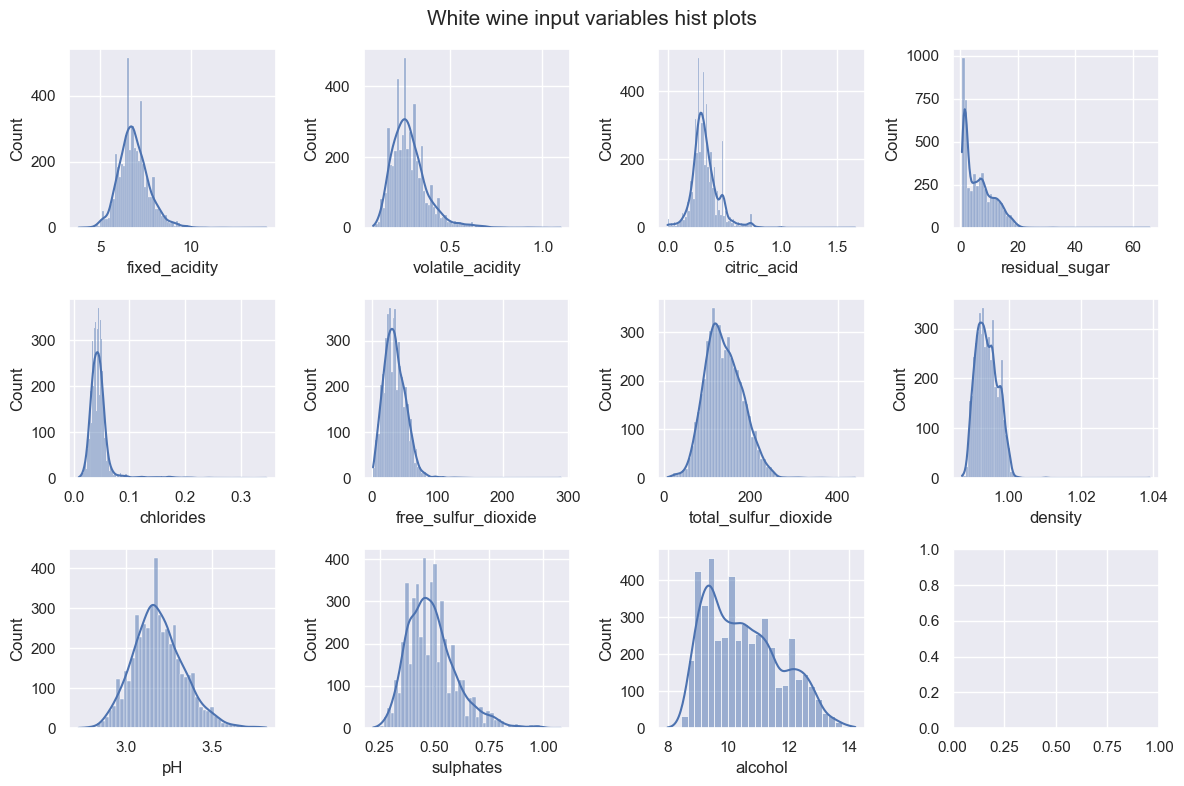

In [12]:
# hist plot for all input variables for both variants
n = white.shape[1]-1 # num of cols less output variable

fig, axs = plt.subplots(math.ceil(n/4), 4, figsize = (12,8))
plt.suptitle('White wine input variables hist plots', fontsize=15)

for i in range(0,n):
    plt.subplot(math.ceil(n/4), 4, i+1)
    sns.histplot(white.iloc[:, i], kde=True)

plt.tight_layout()
plt.show()

fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000         -0.256131     0.671703   
volatile_acidity          -0.256131          1.000000    -0.552496   
citric_acid                0.671703         -0.552496     1.000000   
residual_sugar             0.114777          0.001918     0.143577   
chlorides                  0.093705          0.061298     0.203823   
free_sulfur_dioxide       -0.153794         -0.010504    -0.060978   
total_sulfur_dioxide      -0.113181          0.076470     0.035533   
density                    0.668047          0.022026     0.364947   
pH                        -0.682978          0.234937    -0.541904   
sulphates                  0.183006         -0.260987     0.312770   
alcohol                   -0.061668         -0.202288     0.109903   
quality                    0.124052         -0.390558     0.226373   

                      residual_sugar  chlorides  free_sulfur_dioxide  \
fixed_acidity               0.114777   0.093705            -0.153794   
volatile_acidity            0.001918   0.061298            -0.010504   
citric_acid                 0.143577   0.203823            -0.060978   
residual_sugar              1.000000   0.055610             0.187049   
chlorides                   0.055610   1.000000             0.005562   
free_sulfur_dioxide         0.187049   0.005562             1.000000   
total_sulfur_dioxide        0.203028   0.047400             0.667666   
density                     0.355283   0.200632            -0.021946   
pH                         -0.085652  -0.265026             0.070377   
sulphates                   0.005527   0.371260             0.051658   
alcohol                     0.042075  -0.221141            -0.069408   
quality                     0.013732  -0.128907            -0.050656   

                      total_sulfur_dioxide   density        pH  sulphates  \
fixed_acidity                    -0.113181  0.668047 -0.682978   0.183006   
volatile_acidity                  0.076470  0.022026  0.234937  -0.260987   
citric_acid                       0.035533  0.364947 -0.541904   0.312770   
residual_sugar                    0.203028  0.355283 -0.085652   0.005527   
chlorides                         0.047400  0.200632 -0.265026   0.371260   
free_sulfur_dioxide               0.667666 -0.021946  0.070377   0.051658   
total_sulfur_dioxide              1.000000  0.071269 -0.066495   0.042947   
density                           0.071269  1.000000 -0.341699   0.148506   
pH                               -0.066495 -0.341699  1.000000  -0.196648   
sulphates                         0.042947  0.148506 -0.196648   1.000000   
alcohol                          -0.205654 -0.496180  0.205633   0.093595   
quality                          -0.185100 -0.174919 -0.057731   0.251397   

                       alcohol   quality  
fixed_acidity        -0.061668  0.124052  
volatile_acidity     -0.202288 -0.390558  
citric_acid           0.109903  0.226373  
residual_sugar        0.042075  0.013732  
chlorides            -0.221141 -0.128907  
free_sulfur_dioxide  -0.069408 -0.050656  
total_sulfur_dioxide -0.205654 -0.185100  
density              -0.496180 -0.174919  
pH                    0.205633 -0.057731  
sulphates             0.093595  0.251397  
alcohol               1.000000  0.476166  
quality               0.476166  1.000000

Text(0.5, 1.0, 'Red wine correlation matrix heatmap')

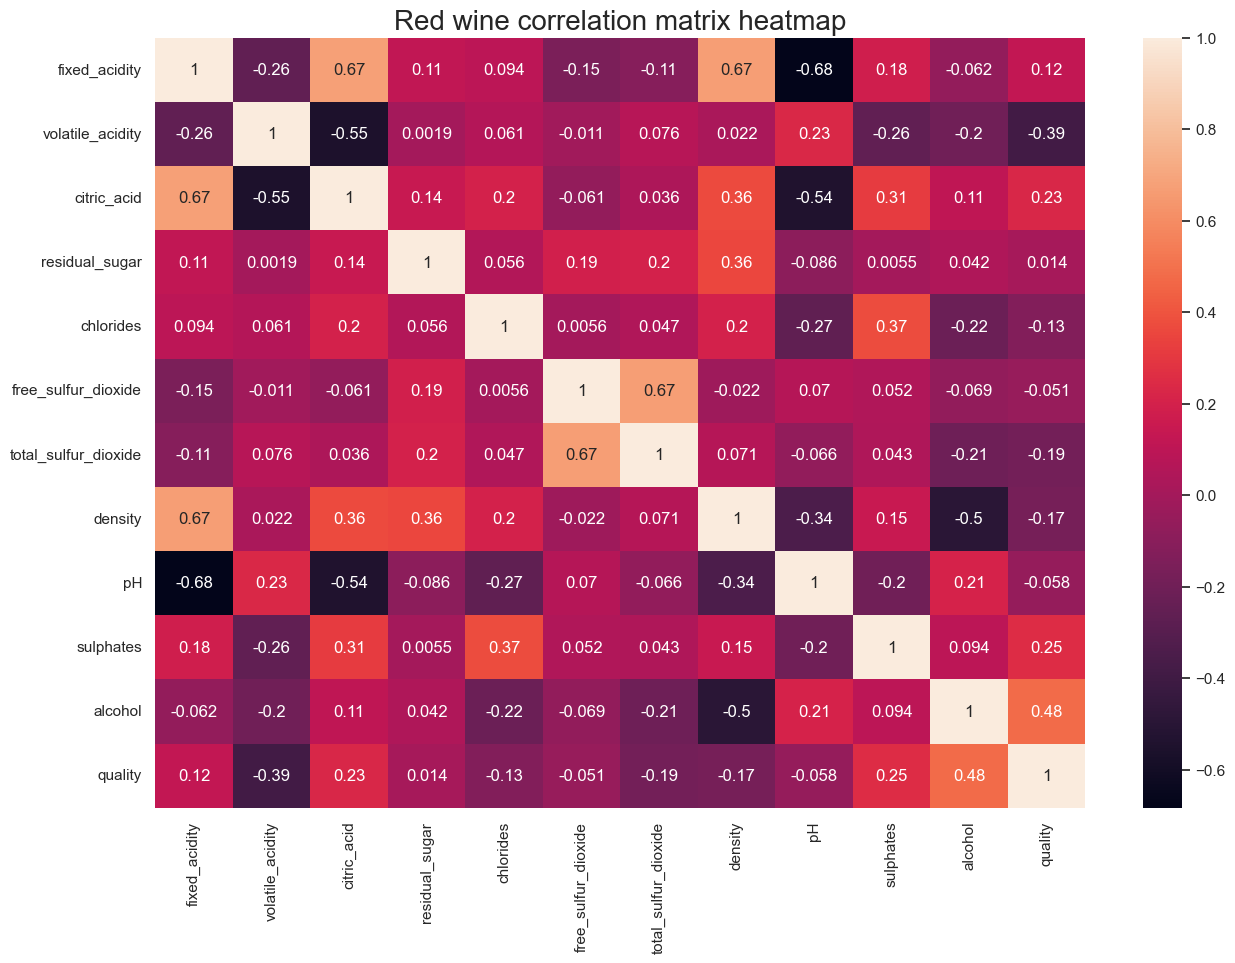

In [13]:
# Red wine
# Correlation matrix and heatmap
red_corr = red.corr()
display(red_corr)
sns.heatmap(red_corr, annot=True)
plt.title('Red wine correlation matrix heatmap', size=20)

fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000         -0.022697     0.289181   
volatile_acidity          -0.022697          1.000000    -0.149472   
citric_acid                0.289181         -0.149472     1.000000   
residual_sugar             0.089021          0.064286     0.094212   
chlorides                  0.023086          0.070512     0.114364   
free_sulfur_dioxide       -0.049396         -0.097012     0.094077   
total_sulfur_dioxide       0.091070          0.089261     0.121131   
density                    0.265331          0.027114     0.149503   
pH                        -0.425858         -0.031915    -0.163748   
sulphates                 -0.017143         -0.035728     0.062331   
alcohol                   -0.120881          0.067718    -0.075729   
quality                   -0.113663         -0.194723    -0.009209   

                      residual_sugar  chlorides  free_sulfur_dioxide  \
fixed_acidity               0.089021   0.023086            -0.049396   
volatile_acidity            0.064286   0.070512            -0.097012   
citric_acid                 0.094212   0.114364             0.094077   
residual_sugar              1.000000   0.088685             0.299098   
chlorides                   0.088685   1.000000             0.101392   
free_sulfur_dioxide         0.299098   0.101392             1.000000   
total_sulfur_dioxide        0.401439   0.198910             0.615501   
density                     0.838966   0.257211             0.294210   
pH                         -0.194133  -0.090439            -0.000618   
sulphates                  -0.026664   0.016763             0.059217   
alcohol                    -0.450631  -0.360189            -0.250104   
quality                    -0.097577  -0.209934             0.008158   

                      total_sulfur_dioxide   density        pH  sulphates  \
fixed_acidity                     0.091070  0.265331 -0.425858  -0.017143   
volatile_acidity                  0.089261  0.027114 -0.031915  -0.035728   
citric_acid                       0.121131  0.149503 -0.163748   0.062331   
residual_sugar                    0.401439  0.838966 -0.194133  -0.026664   
chlorides                         0.198910  0.257211 -0.090439   0.016763   
free_sulfur_dioxide               0.615501  0.294210 -0.000618   0.059217   
total_sulfur_dioxide              1.000000  0.529881  0.002321   0.134562   
density                           0.529881  1.000000 -0.093591   0.074493   
pH                                0.002321 -0.093591  1.000000   0.155951   
sulphates                         0.134562  0.074493  0.155951   1.000000   
alcohol                          -0.448892 -0.780138  0.121432  -0.017433   
quality                          -0.174737 -0.307123  0.099427   0.053678   

                       alcohol   quality  
fixed_acidity        -0.120881 -0.113663  
volatile_acidity      0.067718 -0.194723  
citric_acid          -0.075729 -0.009209  
residual_sugar       -0.450631 -0.097577  
chlorides            -0.360189 -0.209934  
free_sulfur_dioxide  -0.250104  0.008158  
total_sulfur_dioxide -0.448892 -0.174737  
density              -0.780138 -0.307123  
pH                    0.121432  0.099427  
sulphates            -0.017433  0.053678  
alcohol               1.000000  0.435575  
quality               0.435575  1.000000

Text(0.5, 1.0, 'White wine correlation matrix heatmap')

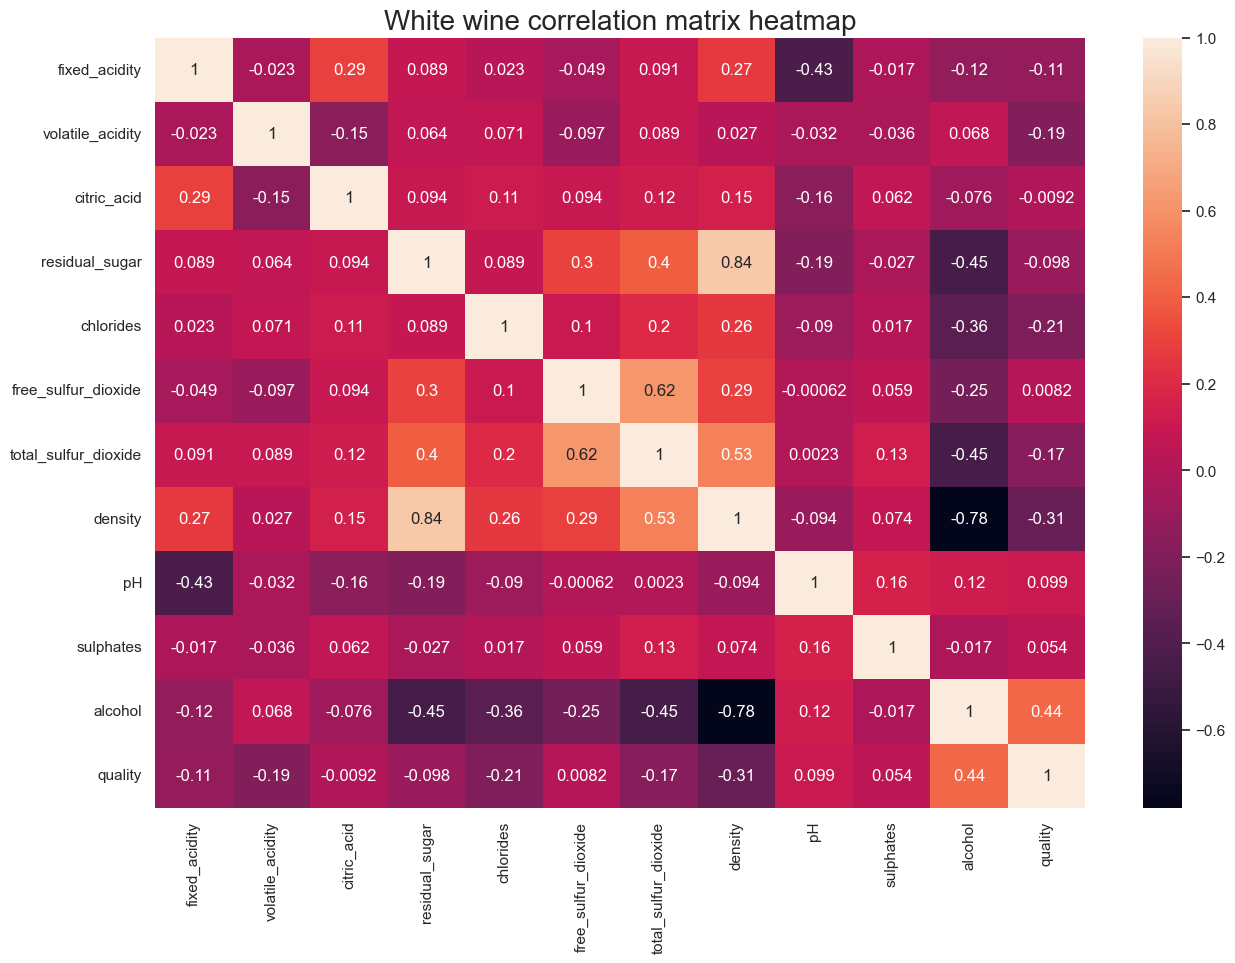

In [14]:
# White wine
# Correlation matrix and heatmap
white_corr = white.corr()
display(white_corr)
sns.heatmap(white_corr, annot=True)
plt.title('White wine correlation matrix heatmap', size=20)

## Regression analysis

### Red wine
- Overall `volatile acidity`, `chloride`, `free sulfur dioxide`, `total sulfur dioxide`, `pH`, `sulphates` and `alcohol` show significance (p-value <0.05) towards predicting quality score of red wine.
- Base on the coefficients of the variables, `volatile acidity`, `chlorides`, `total sulfur dioxide` and `pH` negatively affects the quality, while the other variables correlates positively.
- This model has adjusted r-squared value of 0.357, which suggest input variables has very moderate effect on the target variable

### White wine
- Overall `fixed acidity`, `volatile acidity`, `chloride`, `free sulfur dioxide`, `sulphates` and `alcohol` show significance (p-value <0.05) towards predicting quality score of red wine.
- Base on the coefficients of the variables, `fixed acidity`, `volatile acidity` and `chlorides` negatively affects the quality, while the other variables correlates positively.
- This model has adjusted r-squared value of 0.257, which suggest input variables has very weak effect on the target variable


In [15]:
## red wine
# Check multi collinearity 
# gather features
input_variables = list(filter(lambda var: var !='quality', list(red.columns)))
features = "+".join(input_variables)

# get y and X dataframes based on this regression:
y, X = dmatrices('quality ~' + features, red, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print('VIF for red wine:')
display(vif.round(1))


VIF for red wine:


VIF Factor              features
0    1710538.5             Intercept
1          7.8         fixed_acidity
2          1.8      volatile_acidity
3          3.1           citric_acid
4          1.7        residual_sugar
5          1.5             chlorides
6          2.0   free_sulfur_dioxide
7          2.2  total_sulfur_dioxide
8          6.3               density
9          3.3                    pH
10         1.4             sulphates
11         3.0               alcohol

In [16]:
# red wine Multi-linear regression 
model = sm.OLS(y, sm.add_constant(X)).fit()
print('Red wine regression summary:')
model.summary()

Red wine regression summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Sun, 08 Oct 2023   Prob (F-statistic):          1.79e-145
Time:                        22:53:38   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:                    1587   BIC:                             3227.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               21.9652     21.195      1.036      0.300     -19.607      63.538
fixed_acidity            0.0250      0.026      0.963      0.336      -0.026       0.076
volatile_acidity        -1.0836      0.121     -8.948      0.000      -1.321      -0.846
citric_acid             -0.1826      0.147     -1.240      0.215      -0.471       0.106
residual_sugar           0.0163      0.015      1.089      0.276      -0.013       0.046
chlorides               -1.8742      0.419     -4.470      0.000      -2.697      -1.052
free_sulfur_dioxide      0.0044      0.002      2.009      0.045       0.000       0.009
total_sulfur_dioxide    -0.0033      0.001     -4.480      0.000      -0.005      -0.002
density                -17.8812     21.633     -0.827      0.409     -60.314      24.551
pH                      -0.4137      0.192     -2.159      0.031      -0.789      -0.038
sulphates                0.9163      0.114      8.014      0.000       0.692       1.141
alcohol                  0.2762      0.026     10.429      0.000       0.224       0.328
==============================================================================
Omnibus:                       27.376   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.965
Skew:                          -0.168   Prob(JB):                     1.27e-09
Kurtosis:                       3.708   Cond. No.                     1.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
# revise regression model
# remove non significant variables
exclude_var = ['quality', 'fixed_acidity', 'citric_acid', 'residual_sugar',
              'density']
input_variables = list(filter(lambda var: var not in exclude_var, list(red.columns)))
features = "+".join(input_variables)

# get y and X dataframes based on this regression:
y, X = dmatrices('quality ~' + features, red, return_type='dataframe')

model = sm.OLS(y, sm.add_constant(X)).fit()
print('Red wine regression summary:')
model.summary()


Red wine regression summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     127.6
Date:                Sun, 08 Oct 2023   Prob (F-statistic):          5.32e-149
Time:                        22:53:38   Log-Likelihood:                -1570.5
No. Observations:                1599   AIC:                             3157.
Df Residuals:                    1591   BIC:                             3200.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.4301      0.403     10.995      0.000       3.640       5.220
volatile_acidity        -1.0128      0.101    -10.043      0.000      -1.211      -0.815
chlorides               -2.0178      0.398     -5.076      0.000      -2.798      -1.238
free_sulfur_dioxide      0.0051      0.002      2.389      0.017       0.001       0.009
total_sulfur_dioxide    -0.0035      0.001     -5.070      0.000      -0.005      -0.002
pH                      -0.4827      0.118     -4.106      0.000      -0.713      -0.252
sulphates                0.8827      0.110      8.031      0.000       0.667       1.098
alcohol                  0.2893      0.017     17.225      0.000       0.256       0.322
==============================================================================
Omnibus:                       24.204   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.245
Skew:                          -0.156   Prob(JB):                     2.22e-08
Kurtosis:                       3.657   Cond. No.                     1.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
## white wine
# Check multi collinearity 
# gather features
input_variables = list(filter(lambda var: var !='quality', list(red.columns)))
features = "+".join(input_variables)

# get y and X dataframes based on this regression:
y, X = dmatrices('quality ~' + features, white, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print('VIF for white wine:')
display(vif.round(1))

VIF for white wine:


VIF Factor              features
0    3067855.6             Intercept
1          2.7         fixed_acidity
2          1.1      volatile_acidity
3          1.2           citric_acid
4         12.6        residual_sugar
5          1.2             chlorides
6          1.8   free_sulfur_dioxide
7          2.2  total_sulfur_dioxide
8         28.2               density
9          2.2                    pH
10         1.1             sulphates
11         7.7               alcohol

In [19]:
# white wine multi linear regressions
exclude_var = ['quality', 'residual_sugar', 'density']

input_variables = list(filter(lambda var: var not in exclude_var, list(red.columns)))
features = "+".join(input_variables)

# get y and X dataframes based on this regression:
y, X = dmatrices('quality ~' + features, white, return_type='dataframe')

model = sm.OLS(y, sm.add_constant(X)).fit()
print('White wine regression summary:')
model.summary()

White wine regression summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     188.6
Date:                Sun, 08 Oct 2023   Prob (F-statistic):          2.54e-308
Time:                        22:53:38   Log-Likelihood:                -5624.7
No. Observations:                4898   AIC:                         1.127e+04
Df Residuals:                    4888   BIC:                         1.133e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.0334      0.338      8.975      0.000       2.371       3.696
fixed_acidity           -0.0577      0.015     -3.833      0.000      -0.087      -0.028
volatile_acidity        -1.8410      0.114    -16.091      0.000      -2.065      -1.617
citric_acid              0.0246      0.097      0.253      0.800      -0.166       0.215
chlorides               -1.6574      0.543     -3.050      0.002      -2.723      -0.592
free_sulfur_dioxide      0.0056      0.001      6.611      0.000       0.004       0.007
total_sulfur_dioxide    -0.0003      0.000     -0.783      0.434      -0.001       0.000
pH                       0.0243      0.082      0.296      0.767      -0.137       0.185
sulphates                0.3760      0.098      3.829      0.000       0.183       0.569
alcohol                  0.3235      0.011     30.295      0.000       0.303       0.344
==============================================================================
Omnibus:                      120.238   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              270.942
Skew:                           0.077   Prob(JB):                     1.46e-59
Kurtosis:                       4.142   Cond. No.                     7.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# revised white wine multi linear regressions
exclude_var = ['quality', 'residual_sugar', 'density', 'citric_acid', 
               'total_sulfur_dioxide', 'pH']

input_variables = list(filter(lambda var: var not in exclude_var, list(red.columns)))
features = "+".join(input_variables)

# get y and X dataframes based on this regression:
y, X = dmatrices('quality ~' + features, white, return_type='dataframe')

model = sm.OLS(y, sm.add_constant(X)).fit()
print('White wine regression summary:')
model.summary()

White wine regression summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     282.9
Date:                Sun, 08 Oct 2023   Prob (F-statistic):          8.42e-312
Time:                        22:53:38   Log-Likelihood:                -5625.1
No. Observations:                4898   AIC:                         1.126e+04
Df Residuals:                    4891   BIC:                         1.131e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.0821      0.170     18.171      0.000       2.750       3.415
fixed_acidity          -0.0597      0.013     -4.567      0.000      -0.085      -0.034
volatile_acidity       -1.8672      0.110    -17.046      0.000      -2.082      -1.652
chlorides              -1.6615      0.538     -3.086      0.002      -2.717      -0.606
free_sulfur_dioxide     0.0052      0.001      7.762      0.000       0.004       0.006
sulphates               0.3710      0.096      3.872      0.000       0.183       0.559
alcohol                 0.3268      0.010     33.052      0.000       0.307       0.346
==============================================================================
Omnibus:                      118.835   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.857
Skew:                           0.078   Prob(JB):                     1.86e-58
Kurtosis:                       4.131   Cond. No.                     2.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""